# Import

In [1]:
import keras.layers as kl
import keras.backend as K
import keras.callbacks as kc
from keras.models import Sequential, load_model, Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import tqdm # progress bar

import os
import tensorflow as tf

Using TensorFlow backend.


# Load data

```
data_root = os.path.join(".","Formatage", "parts")

# load ilot1_lum
with open(os.path.join(data_root, "ilot1.lum.csv"), "r") as f:
    data = f.read().splitlines()
data = [d.split(";") for d in data]
```

In [2]:
file_name = "ilot1.co2.csv"

# to get inputs whatever the OS
data_root = os.path.join(".", "Formatage", "parts")
data = pd.read_csv(os.path.join(data_root, file_name), sep= ";")

data.head()

,ilot,type,timestamp,value
0,ilot1,co2,1505127194,357
1,ilot1,co2,1505127254,381
2,ilot1,co2,1505127314,344
3,ilot1,co2,1505127375,338
4,ilot1,co2,1505127435,351


# Prepare data

In [3]:
serie_length = 10 # nbr of data taken for training set
to_predict = 1 # how far to predict (nbr of serie_length far)
# rq : the further we try to predict, the inaccurate results are, obviously true

values = data["value"].values

In [18]:
# remove beginning
nb_todelete = len(values) % serie_length
values = values[nb_todelete:]

# create X and Y
X, Y = [], []
for i in range(0, len(values) - (serie_length * to_predict), serie_length):
    window = values[i : i + serie_length]
    next_window = values[i + serie_length * to_predict : i + serie_length * (to_predict + 1)]
    
    X.append(window)
    Y.append(next_window.mean())

X = np.array(X)
Y = np.array(Y)
# X.shape, Y.shape
X.min(), X.max()

(84, 1990)

In [5]:
# Normalisation entre min et max vers des valeurs de 0 à 1
X = np.interp(X, (X.min(), X.max()), (0, 1))
Y = np.interp(Y, (Y.min(), Y.max()), (0, 1))

In [6]:
# split between training and validation
ratio = 0.8
split_index = int(len(X) * ratio)

X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

# cause LSTM wants 3d vectors
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

# Training

In [7]:
K.clear_session()
model_name = "models/model_" + file_name[:-4] + "_" + str(serie_length) + "_" + str(to_predict) + ".h5"

# Sequential way to define model
# model = Sequential()
# model.add(kl.Input(X_train[0].shape))
# model.add(kl.LSTM(16))
# model.add(kl.Dense(1, activation="sigmoid"))
# model.compile(loss = 'mse', optimizer = 'adam')
# model.summary()

# Recusive way to define model
inp = kl.Input(X_train[0].shape)
rnn = kl.LSTM(64)(inp)
#rnn = kl.CuDNNGRU(64)(inp)

dense = kl.Dense(16, activation = "relu")(rnn)
dense = kl.Dense(1, activation = "sigmoid")(dense)

model = Model(inputs = [inp], outputs = [dense])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 17,953
Trainable params: 17,953
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss="mse", optimizer="adam")

In [9]:
# permet d'arrêter le training avant la fin si rien n'est améliorer en 10 epochs
early_stop = kc.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
# enregistre le modèle si le val_loss est meilleur que l'actuel meilleur modèle
checkpoint = kc.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# permet de revenir en arrière si rencontre avec un min local en reduisant le LR
reduce_lr = kc.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=25, verbose=1, mode='min', min_lr=1e-6)

callbacks = [early_stop, checkpoint, reduce_lr]


In [10]:
history = model.fit(
    X_train, Y_train,
    validation_data = (X_test, Y_test),
    epochs = 10,
    batch_size = 32,
    callbacks = callbacks
)

Instructions for updating:
Use tf.cast instead.
Train on 33998 samples, validate on 8500 samples
Epoch 1/10
33998/33998 [==============================] - 17s 486us/step - loss: 0.0055 - val_loss: 2.2088e-04

Epoch 00001: val_loss improved from inf to 0.00022, saving model to models/model_ilot1.co2_10_1.h5
Epoch 2/10
33998/33998 [==============================] - 18s 537us/step - loss: 3.2207e-04 - val_loss: 1.3111e-04

Epoch 00002: val_loss improved from 0.00022 to 0.00013, saving model to models/model_ilot1.co2_10_1.h5
Epoch 3/10
33998/33998 [==============================] - 16s 459us/step - loss: 2.7593e-04 - val_loss: 1.1224e-04

Epoch 00003: val_loss improved from 0.00013 to 0.00011, saving model to models/model_ilot1.co2_10_1.h5
Epoch 4/10
33998/33998 [==============================] - 16s 462us/step - loss: 2.3723e-04 - val_loss: 1.0188e-04

Epoch 00004: val_loss improved from 0.00011 to 0.00010, saving model to models/model_ilot1.co2_10_1.h5
Epoch 5/10
33998/33998 [===========

In [11]:
model = load_model(model_name)

In [12]:
Y_test_pred = model.predict(X_test)

# Data Representation

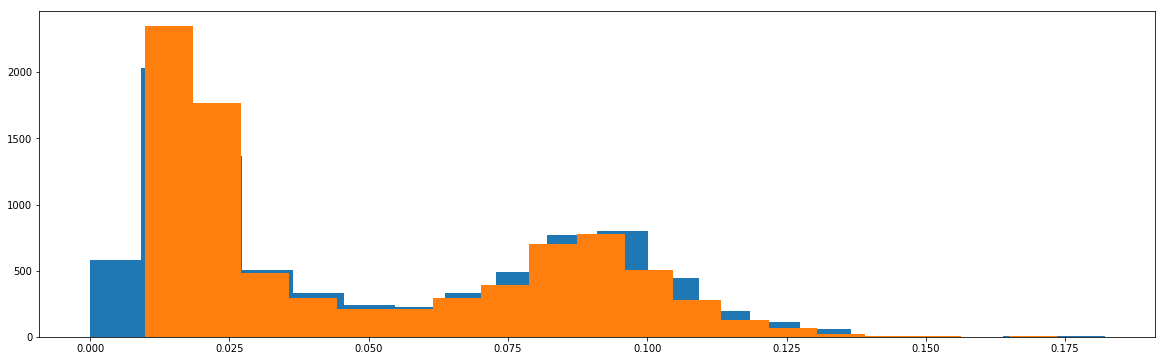

In [16]:
plt.figure(0, figsize = (20, 6))

plt.hist(Y_test, bins = 20) # blue : actual data
plt.hist(Y_test_pred, bins = 20) # orange : predicted data
plt.show()

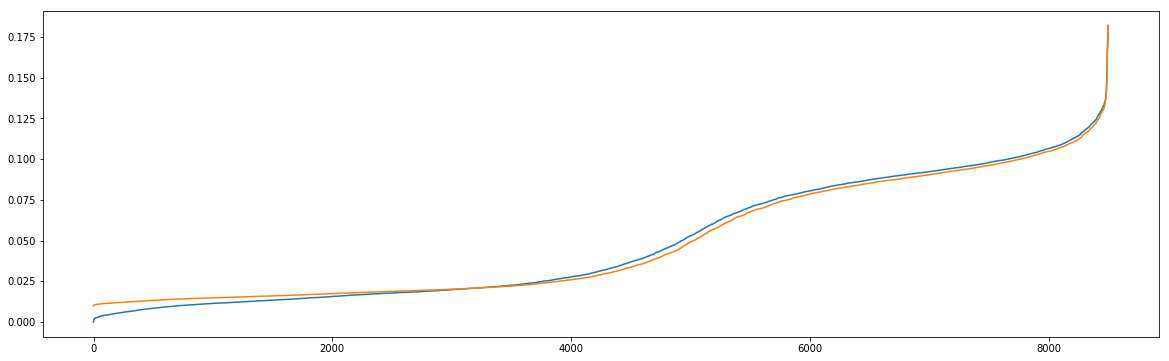

In [17]:
plt.figure(0, figsize = (20, 6))
plt.plot(sorted(Y_test))
plt.plot(sorted(Y_test_pred))

plt.show()

In [15]:
error_is = 100 * sklearn.metrics.mean_squared_error(Y_test, Y_test_pred)
error_is.round(4)

0.0067